In [30]:
from tensorflow.python.keras import optimizers

In [6]:
# La libreria keras es la que se usa por defecto para redes neuronales
# Nota: Es necesario tambien instalar la libreria tensorflow para no tener problemas con el codigo
# Seguramente para una version de python por encima de la 3.6 existan problemas...
# .... para ello usar este comando: pip3 install --upgrade tensorflow-gpu


from keras.layers import Input, Dense
from keras import regularizers, models, optimizers

# Comando adicional, es necesario instalar esta libreria para que trabaje bien
# Dado que optimizers nos ofrece es la segunda version de Adam
from tensorflow.python.keras.optimizer_v2.adam import Adam


from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

# Lectura del dataset

In [11]:
# Excel que contiene las curvas yield
df = pd.read_csv('yield_curve.csv', sep=',')

# Transformar el dia a un mejor formato
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

# Colocar los dias como indice de la base de datos
df.set_index('Date', drop=True, inplace=True)

df.index.names = [None]

df.drop('Index', axis=1, inplace=True)

n_obs = len(df)

In [12]:
df

,1M,2M,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
1992-02-29,0.09610,0.09610,0.09610,0.09580,0.08980,0.08640,0.08490,0.08370,0.08260,0.08170,0.08100,0.08060,0.08030,0.08040
1992-03-31,0.09700,0.09700,0.09700,0.09690,0.09120,0.08890,0.08770,0.08640,0.08520,0.08410,0.08330,0.08270,0.08230,0.08230
1992-04-30,0.09750,0.09750,0.09750,0.09750,0.09200,0.08920,0.08770,0.08620,0.08480,0.08370,0.08280,0.08220,0.08170,0.08160
1992-05-31,0.09780,0.09785,0.09790,0.09790,0.09200,0.08890,0.08740,0.08600,0.08470,0.08360,0.08280,0.08210,0.08170,0.08150
1992-06-30,0.09740,0.09745,0.09750,0.09750,0.09310,0.09040,0.08890,0.08740,0.08600,0.08480,0.08390,0.08320,0.08270,0.08250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-31,-0.00098,-0.00066,-0.00033,0.00039,-0.00005,0.00036,0.00115,0.00225,0.00354,0.00491,0.00629,0.00761,0.00884,0.00991
2015-09-30,-0.00113,-0.00077,-0.00040,0.00029,-0.00032,-0.00014,0.00053,0.00157,0.00277,0.00407,0.00540,0.00669,0.00789,0.00896
2015-10-31,-0.00119,-0.00094,-0.00068,0.00006,-0.00101,-0.00092,-0.00030,0.00070,0.00189,0.00321,0.00458,0.00593,0.00718,0.00831
2015-11-30,-0.00161,-0.00138,-0.00114,-0.00043,-0.00184,-0.00193,-0.00144,-0.00041,0.00086,0.00227,0.00373,0.00517,0.00652,0.00775


# Visualizando los datos

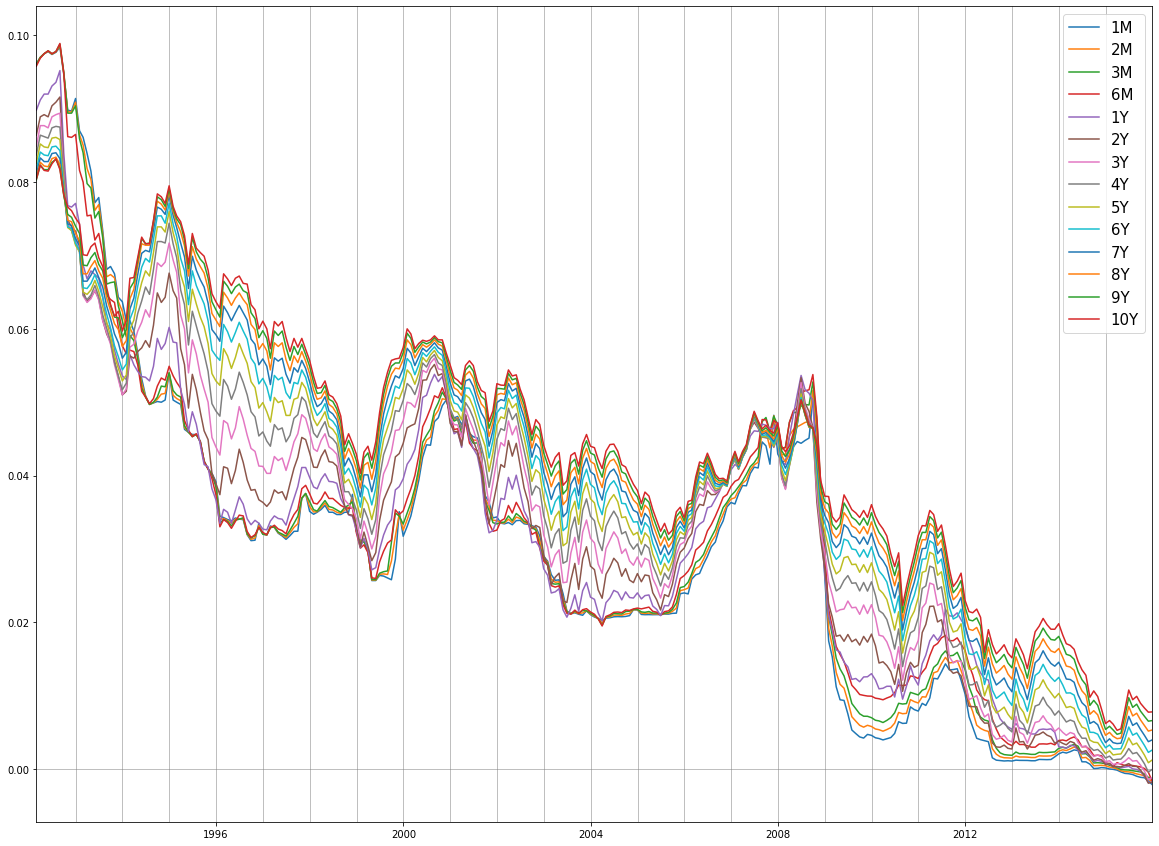

In [13]:
plt.figure(figsize=(20, 15))

plt.plot(df.index, df)

plt.xlim(df.index.min(), df.index.max())
plt.axhline(y=0, c="grey", linewidth=0.5, zorder=0)
plt.legend(df.columns, fontsize=15)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=datetime(i, 1, 1), c="grey", linewidth=0.5, zorder=0)

### El siguiente grafico es para ver cada curva por cada año del dataset

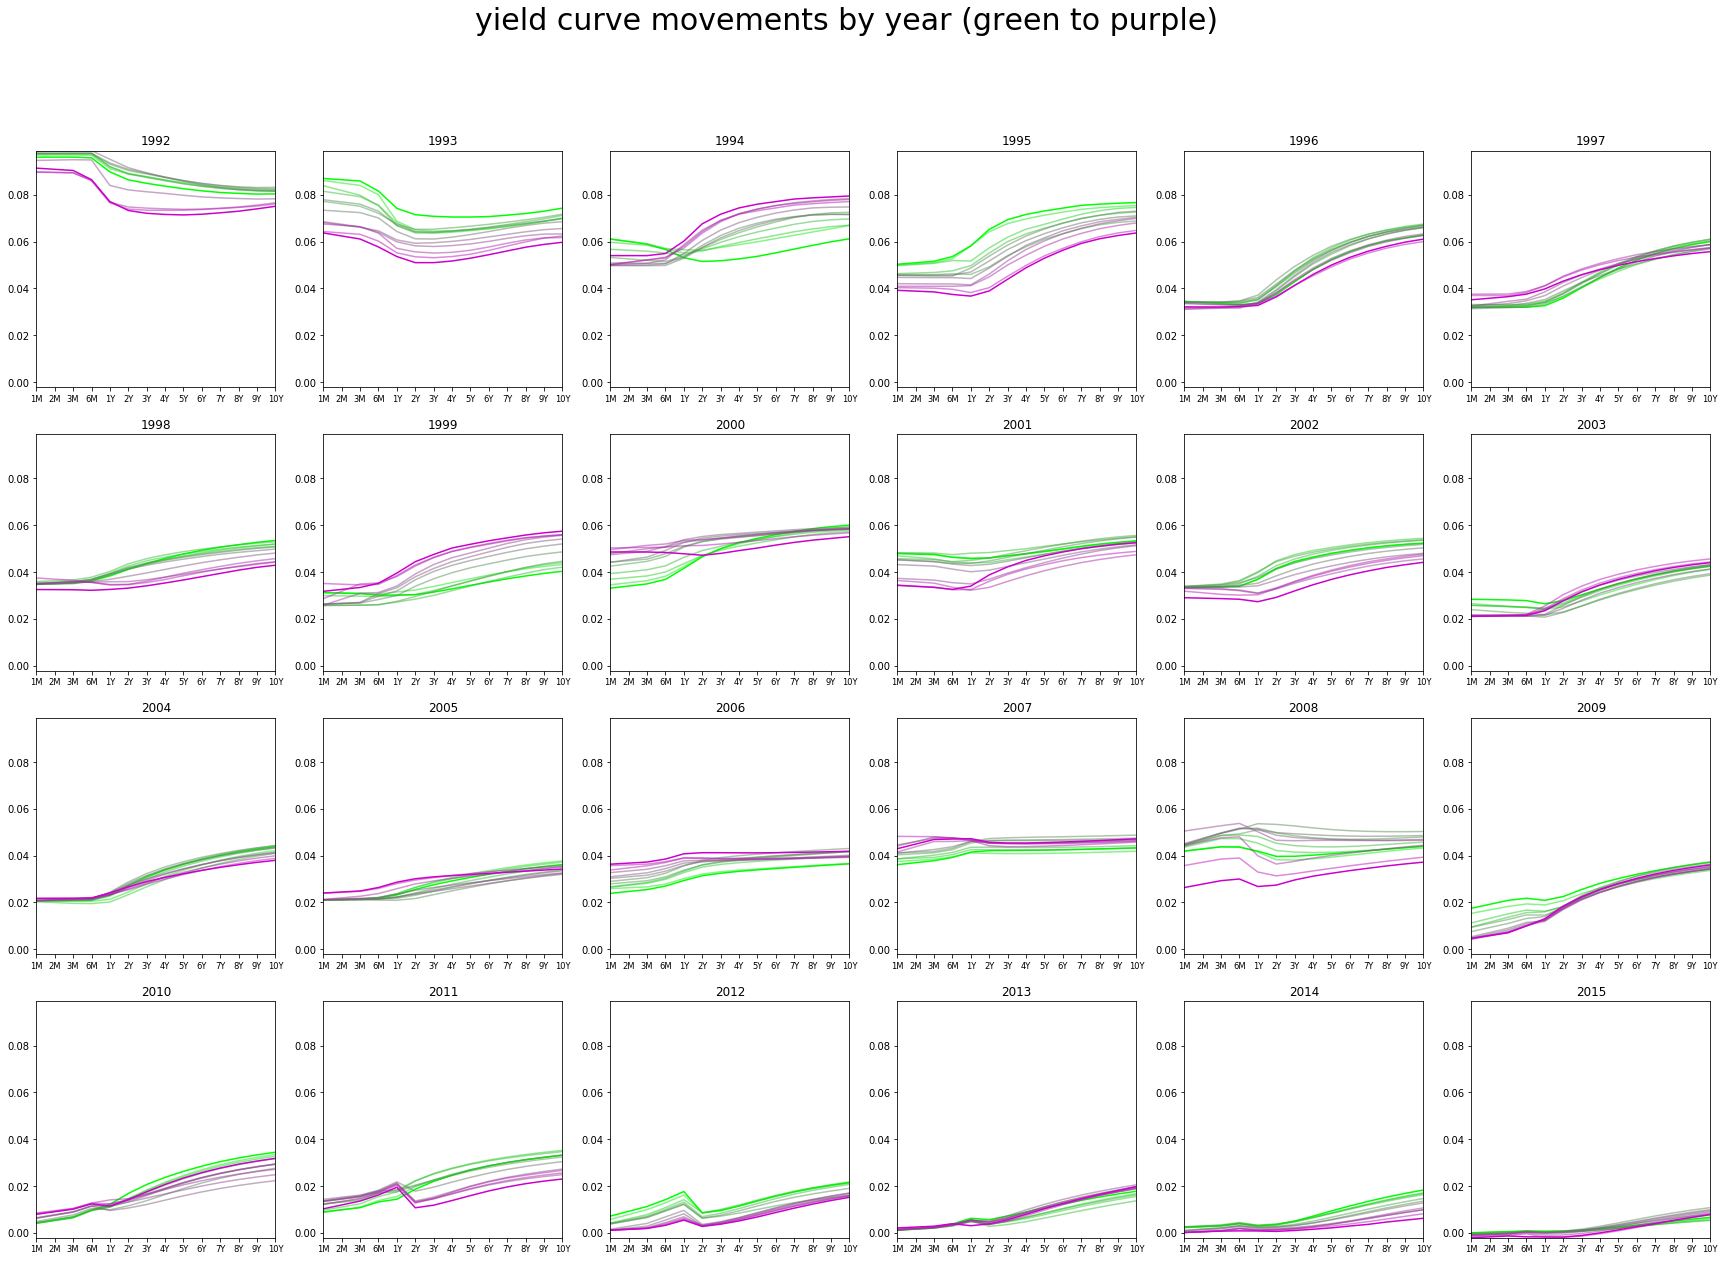

In [14]:
# 6 columnas de grafica
cols = 6
# Numero de años en la base de daots
num_years = df.index.max().year - df.index.min().year
# Acomodar el grafico para que esten todos los años
rows = int(np.ceil(num_years/cols))

# De verde a morado el tiempo de la yield curve
plt.figure(figsize=(30, (30/cols)*rows))
plt.suptitle('yield curve movements by year (green to purple)', fontsize=30)

colnum = 0
rownum = 0
for year in range(df.index.min().year, df.index.max().year+1):
    year_start = datetime(year, 1, 1)
    year_end = datetime(year, 12, 31)
    
    plt.subplot2grid((rows, cols), (rownum, colnum), colspan=1, rowspan=1)
    plt.title('{0}'.format(year))
    plt.xlim(0, len(df.columns)-1)
    plt.ylim(np.min(df.values), np.max(df.values))
    plt.xticks(range(len(df.columns)), df.columns, size='small')
    
    year_curves = df.loc[year_start:year_end].values    
    gradient = np.linspace([0, 1, 0, 1], [0.8, 0, 0.8, 1], year_curves.shape[0])
    gradient[1:-1, -1] = 0.5
    
    for yield_curve, colour in zip(year_curves, gradient):
        plt.plot(yield_curve, c=colour)

    if colnum != cols-1:
        colnum += 1
    else:
        colnum = 0
        rownum +=1

# Implementaciónn del PCA

In [15]:
# Se usan los 3 primeros componentes principales
pca_model = PCA(n_components=3, copy=True, whiten=False)
# Se corre el PCA para el data set
pca_model.fit(df)

# Proyectar el dataset en cada uno de los componentes principales
df_pca = pd.DataFrame(pca_model.transform(df), index=df.index)

# En caso de que queramos retornar a las observaciones originales, nos funciona para calcular el error
df_pca_recon = pd.DataFrame(pca_model.inverse_transform(df_pca), index=df.index, columns=df.columns)

In [16]:
df_pca.head()

,0,1,2
1992-02-29,0.189681,0.031657,-0.002092
1992-03-31,0.196655,0.029239,-0.003471
1992-04-30,0.196720,0.031033,-0.003950
1992-05-31,0.196820,0.031674,-0.003434
1992-06-30,0.199527,0.029321,-0.005054


# Graficando el error de cada variable por PCA

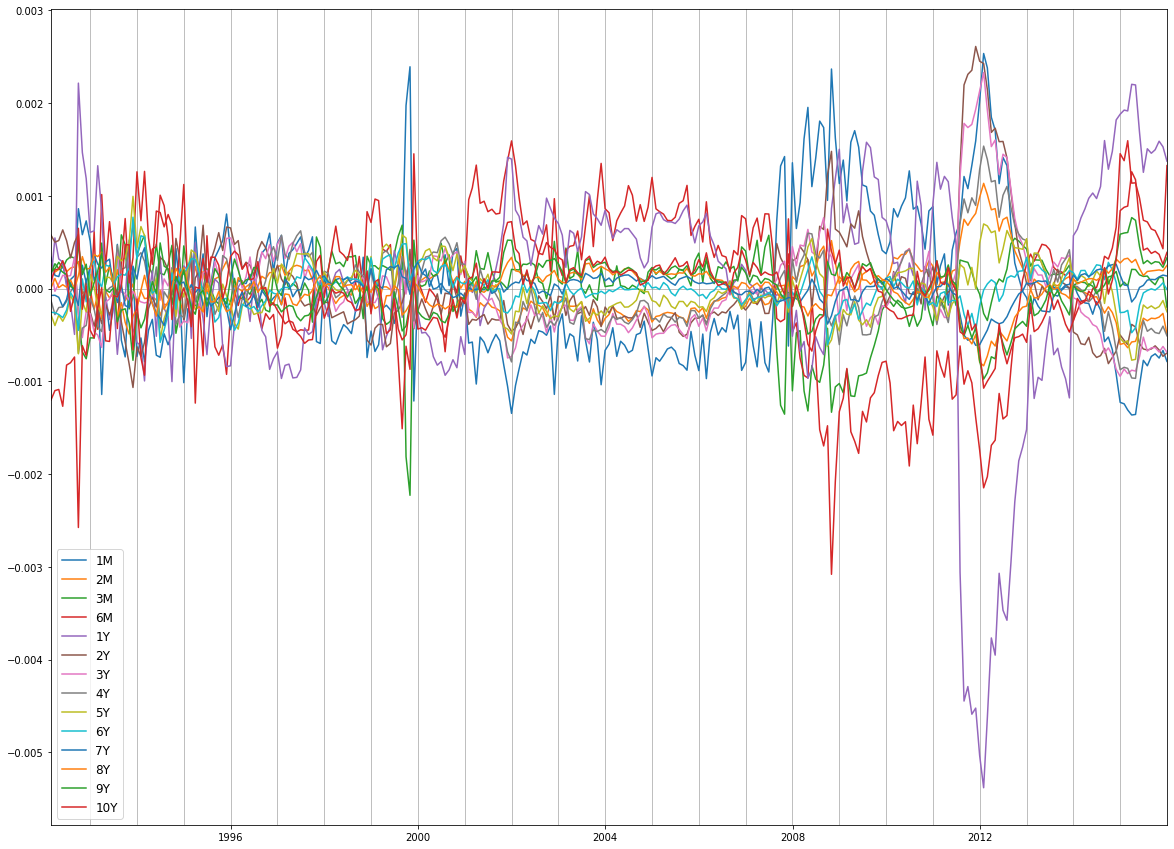

In [17]:
plt.figure(figsize=(20,15))

# Plotting the difference between the reconstructed value and the original
plt.plot(df.index, df_pca_recon-df.values)
plt.xlim(df.index.min(), df.index.max())
plt.legend(df.columns, fontsize=12)
plt.axhline(y=0, c="grey", linewidth=0.5, zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(datetime(i,1,1))-1],
                c="grey", linewidth=0.5, zorder=0)

In [18]:
# Evaluando cuanto explica cada componente
for i, pc in enumerate(pca_model.explained_variance_ratio_):
    print('PC {0}:\t{1:5.2f}%'.format(i+1, pc*100.0))

PC 1:	95.53%
PC 2:	 4.07%
PC 3:	 0.33%


# Vectores de carga

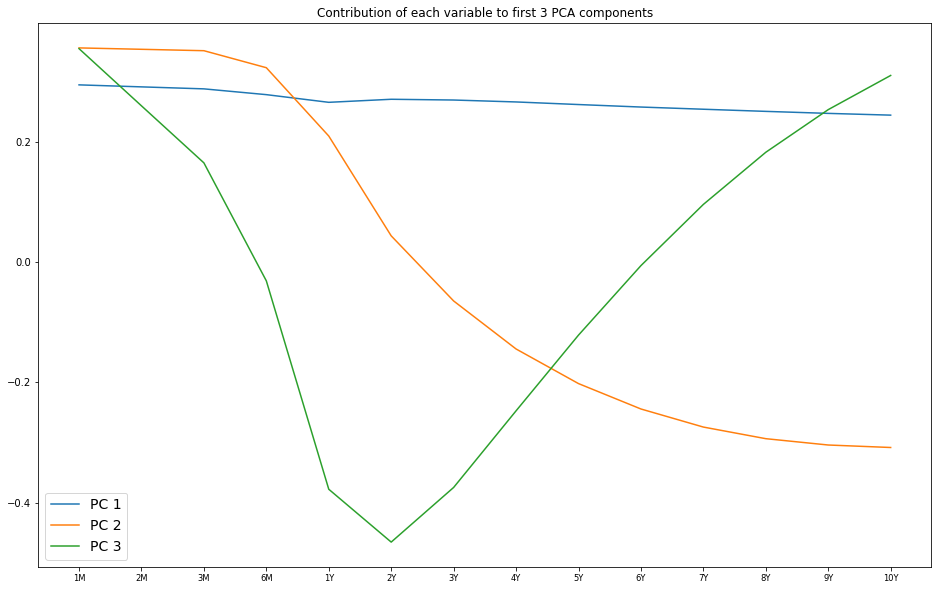

In [19]:
fig = plt.figure(figsize=(16,10))
plt.title('Contribution of each variable to first {0} PCA components'.format(pca_model.n_components))

plt.plot(np.transpose(pca_model.components_[0]), label='PC 1')
plt.plot(np.transpose(pca_model.components_[1]), label='PC 2')
plt.plot(np.transpose(pca_model.components_[2]), label='PC 3')
plt.xticks(range(len(df.columns)), df.columns, size='small')

plt.legend(fontsize=14);

# Autoencoders lineales

In [37]:
def LinearAE(y, dimension, learning_rate = 1e-4, regularization = 1e-5, epochs=10):
    
    input_layer = Input(shape=(y.shape[1],))
    
    # the encoder layer transforms the input into a representation of size `dimension`
    encoder = Dense(dimension, activation='linear',
                    kernel_regularizer=regularizers.l2(regularization))(input_layer)
    
    # the decoder layer transforms the encoded representation back to the original size
    decoder = Dense(y.shape[1], activation='linear',
                    kernel_regularizer=regularizers.l2(regularization))(encoder)
    
    adam=Adam(lr=learning_rate)
    autoencoder = models.Model(input_layer, decoder)
    autoencoder.compile(optimizer=optimizers.adam_v2.Adam(lr=learning_rate), loss='mean_squared_error')
    
    # the autoencoder aims to map the input back onto 
    # itself: the input data are also the output targets
    autoencoder.fit(y, y, epochs=epochs, batch_size=4, shuffle=True)
    
    return autoencoder

In [38]:
ae_model = LinearAE(df.values, 3, regularization=0, epochs=2000)


Epoch 1/2000
72/72 [==============================] - 0s 929us/step - loss: 0.0016
Epoch 2/2000
72/72 [==============================] - 0s 1ms/step - loss: 8.3683e-04
Epoch 3/2000
72/72 [==============================] - 0s 1000us/step - loss: 5.7906e-04
Epoch 4/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.8661e-04
Epoch 5/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.5624e-04
Epoch 6/2000
72/72 [==============================] - 0s 986us/step - loss: 3.0639e-04
Epoch 7/2000
72/72 [==============================] - 0s 1ms/step - loss: 2.3449e-04
Epoch 8/2000
72/72 [==============================] - 0s 1ms/step - loss: 2.3114e-04
Epoch 9/2000
72/72 [==============================] - 0s 1ms/step - loss: 2.3501e-04
Epoch 10/2000
72/72 [==============================] - 0s 1ms/step - loss: 2.2924e-04
Epoch 11/2000
72/72 [==============================] - 0s 1ms/step - loss: 2.3300e-04
Epoch 12/2000
72/72 [==============================] - 0s 2m

72/72 [==============================] - 0s 972us/step - loss: 2.0123e-05
Epoch 96/2000
72/72 [==============================] - 0s 859us/step - loss: 1.6919e-05
Epoch 97/2000
72/72 [==============================] - 0s 915us/step - loss: 1.5110e-05
Epoch 98/2000
72/72 [==============================] - 0s 873us/step - loss: 1.7993e-05
Epoch 99/2000
72/72 [==============================] - 0s 859us/step - loss: 1.6006e-05
Epoch 100/2000
72/72 [==============================] - 0s 873us/step - loss: 1.4712e-05
Epoch 101/2000
72/72 [==============================] - 0s 901us/step - loss: 1.6773e-05
Epoch 102/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.6365e-05
Epoch 103/2000
72/72 [==============================] - 0s 929us/step - loss: 1.6140e-05
Epoch 104/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.6421e-05
Epoch 105/2000
72/72 [==============================] - 0s 873us/step - loss: 1.6775e-05
Epoch 106/2000
72/72 [======================

72/72 [==============================] - 0s 1ms/step - loss: 9.6571e-06
Epoch 189/2000
72/72 [==============================] - 0s 958us/step - loss: 9.2035e-06
Epoch 190/2000
72/72 [==============================] - 0s 1ms/step - loss: 9.7580e-06
Epoch 191/2000
72/72 [==============================] - 0s 958us/step - loss: 9.0467e-06
Epoch 192/2000
72/72 [==============================] - 0s 859us/step - loss: 8.5232e-06
Epoch 193/2000
72/72 [==============================] - 0s 887us/step - loss: 9.2766e-06
Epoch 194/2000
72/72 [==============================] - 0s 887us/step - loss: 1.0119e-05
Epoch 195/2000
72/72 [==============================] - 0s 887us/step - loss: 9.0460e-06
Epoch 196/2000
72/72 [==============================] - 0s 845us/step - loss: 8.3437e-06
Epoch 197/2000
72/72 [==============================] - 0s 915us/step - loss: 9.1446e-06
Epoch 198/2000
72/72 [==============================] - 0s 958us/step - loss: 8.8840e-06
Epoch 199/2000
72/72 [==================

72/72 [==============================] - 0s 1ms/step - loss: 2.8270e-06
Epoch 281/2000
72/72 [==============================] - 0s 901us/step - loss: 3.0446e-06
Epoch 282/2000
72/72 [==============================] - 0s 901us/step - loss: 2.9765e-06
Epoch 283/2000
72/72 [==============================] - 0s 887us/step - loss: 3.1656e-06
Epoch 284/2000
72/72 [==============================] - 0s 901us/step - loss: 3.2230e-06
Epoch 285/2000
72/72 [==============================] - 0s 887us/step - loss: 2.9938e-06
Epoch 286/2000
72/72 [==============================] - 0s 887us/step - loss: 2.9181e-06
Epoch 287/2000
72/72 [==============================] - 0s 887us/step - loss: 2.9383e-06
Epoch 288/2000
72/72 [==============================] - 0s 901us/step - loss: 2.7530e-06
Epoch 289/2000
72/72 [==============================] - 0s 1ms/step - loss: 2.7139e-06
Epoch 290/2000
72/72 [==============================] - 0s 1ms/step - loss: 2.4977e-06
Epoch 291/2000
72/72 [====================

72/72 [==============================] - 0s 944us/step - loss: 1.9760e-06
Epoch 374/2000
72/72 [==============================] - 0s 1ms/step - loss: 2.0111e-06
Epoch 375/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.7716e-06
Epoch 376/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.8040e-06
Epoch 377/2000
72/72 [==============================] - 0s 915us/step - loss: 1.9359e-06
Epoch 378/2000
72/72 [==============================] - 0s 1ms/step - loss: 2.0325e-06
Epoch 379/2000
72/72 [==============================] - 0s 887us/step - loss: 1.9307e-06
Epoch 380/2000
72/72 [==============================] - 0s 901us/step - loss: 1.8427e-06
Epoch 381/2000
72/72 [==============================] - 0s 887us/step - loss: 1.8524e-06
Epoch 382/2000
72/72 [==============================] - 0s 915us/step - loss: 1.9957e-06
Epoch 383/2000
72/72 [==============================] - 0s 887us/step - loss: 1.8229e-06
Epoch 384/2000
72/72 [======================

72/72 [==============================] - 0s 1ms/step - loss: 1.7669e-06
Epoch 466/2000
72/72 [==============================] - 0s 958us/step - loss: 1.7205e-06
Epoch 467/2000
72/72 [==============================] - 0s 845us/step - loss: 1.9534e-06
Epoch 468/2000
72/72 [==============================] - 0s 859us/step - loss: 1.7262e-06
Epoch 469/2000
72/72 [==============================] - 0s 901us/step - loss: 1.6438e-06
Epoch 470/2000
72/72 [==============================] - 0s 901us/step - loss: 1.8290e-06
Epoch 471/2000
72/72 [==============================] - 0s 972us/step - loss: 1.9389e-06
Epoch 472/2000
72/72 [==============================] - 0s 929us/step - loss: 1.7546e-06
Epoch 473/2000
72/72 [==============================] - 0s 972us/step - loss: 1.6463e-06
Epoch 474/2000
72/72 [==============================] - 0s 901us/step - loss: 1.9173e-06
Epoch 475/2000
72/72 [==============================] - 0s 873us/step - loss: 1.8370e-06
Epoch 476/2000
72/72 [================

72/72 [==============================] - 0s 915us/step - loss: 1.4809e-06
Epoch 559/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.5107e-06
Epoch 560/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.6161e-06
Epoch 561/2000
72/72 [==============================] - 0s 986us/step - loss: 1.5579e-06
Epoch 562/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.7299e-06
Epoch 563/2000
72/72 [==============================] - 0s 901us/step - loss: 1.5438e-06
Epoch 564/2000
72/72 [==============================] - 0s 901us/step - loss: 1.6256e-06
Epoch 565/2000
72/72 [==============================] - 0s 915us/step - loss: 1.6925e-06
Epoch 566/2000
72/72 [==============================] - 0s 873us/step - loss: 1.6953e-06
Epoch 567/2000
72/72 [==============================] - 0s 859us/step - loss: 1.5103e-06
Epoch 568/2000
72/72 [==============================] - 0s 901us/step - loss: 1.7335e-06
Epoch 569/2000
72/72 [====================

72/72 [==============================] - 0s 1ms/step - loss: 1.6687e-06
Epoch 651/2000
72/72 [==============================] - 0s 958us/step - loss: 1.4507e-06
Epoch 652/2000
72/72 [==============================] - 0s 887us/step - loss: 1.3739e-06
Epoch 653/2000
72/72 [==============================] - 0s 887us/step - loss: 1.7283e-06
Epoch 654/2000
72/72 [==============================] - 0s 887us/step - loss: 1.6891e-06
Epoch 655/2000
72/72 [==============================] - 0s 887us/step - loss: 1.4828e-06
Epoch 656/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.4418e-06
Epoch 657/2000
72/72 [==============================] - 0s 944us/step - loss: 1.3903e-06
Epoch 658/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.5479e-06
Epoch 659/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.4712e-06
Epoch 660/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.5793e-06
Epoch 661/2000
72/72 [========================

72/72 [==============================] - 0s 859us/step - loss: 1.4164e-06
Epoch 744/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.3964e-06
Epoch 745/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.4742e-06
Epoch 746/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.4067e-06
Epoch 747/2000
72/72 [==============================] - 0s 887us/step - loss: 1.5335e-06
Epoch 748/2000
72/72 [==============================] - 0s 1000us/step - loss: 1.5123e-06
Epoch 749/2000
72/72 [==============================] - 0s 901us/step - loss: 1.5713e-06
Epoch 750/2000
72/72 [==============================] - 0s 915us/step - loss: 1.4480e-06
Epoch 751/2000
72/72 [==============================] - 0s 986us/step - loss: 1.4064e-06
Epoch 752/2000
72/72 [==============================] - 0s 915us/step - loss: 1.4134e-06
Epoch 753/2000
72/72 [==============================] - 0s 929us/step - loss: 1.3646e-06
Epoch 754/2000
72/72 [===================

Epoch 836/2000
72/72 [==============================] - 0s 929us/step - loss: 1.5106e-06
Epoch 837/2000
72/72 [==============================] - 0s 859us/step - loss: 1.1715e-06
Epoch 838/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.2065e-06
Epoch 839/2000
72/72 [==============================] - 0s 873us/step - loss: 1.2963e-06
Epoch 840/2000
72/72 [==============================] - 0s 1000us/step - loss: 1.4122e-06
Epoch 841/2000
72/72 [==============================] - 0s 887us/step - loss: 1.3021e-06
Epoch 842/2000
72/72 [==============================] - 0s 901us/step - loss: 1.3599e-06
Epoch 843/2000
72/72 [==============================] - 0s 887us/step - loss: 1.3497e-06
Epoch 844/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.1851e-06
Epoch 845/2000
72/72 [==============================] - 0s 958us/step - loss: 1.2885e-06
Epoch 846/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.2821e-06
Epoch 847/2000
72/72 [====

72/72 [==============================] - 0s 1ms/step - loss: 1.1881e-06
Epoch 929/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.1810e-06
Epoch 930/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.0216e-06
Epoch 931/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.1655e-06
Epoch 932/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.0752e-06
Epoch 933/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.0697e-06
Epoch 934/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.2104e-06
Epoch 935/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.1833e-06
Epoch 936/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.1707e-06
Epoch 937/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.0222e-06
Epoch 938/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.0531e-06
Epoch 939/2000
72/72 [==============================] - 0s

72/72 [==============================] - 0s 1ms/step - loss: 1.0366e-06
Epoch 1022/2000
72/72 [==============================] - 0s 901us/step - loss: 1.0353e-06
Epoch 1023/2000
72/72 [==============================] - 0s 1000us/step - loss: 9.8959e-07
Epoch 1024/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.0248e-06
Epoch 1025/2000
72/72 [==============================] - 0s 1000us/step - loss: 1.0555e-06
Epoch 1026/2000
72/72 [==============================] - 0s 1ms/step - loss: 9.8306e-07
Epoch 1027/2000
72/72 [==============================] - 0s 1ms/step - loss: 1.0340e-06
Epoch 1028/2000
72/72 [==============================] - 0s 915us/step - loss: 9.2588e-07
Epoch 1029/2000
72/72 [==============================] - 0s 1ms/step - loss: 9.3592e-07
Epoch 1030/2000
72/72 [==============================] - 0s 944us/step - loss: 8.7244e-07
Epoch 1031/2000
72/72 [==============================] - 0s 1ms/step - loss: 9.8734e-07
Epoch 1032/2000
72/72 [=============

72/72 [==============================] - 0s 986us/step - loss: 8.5842e-07
Epoch 1114/2000
72/72 [==============================] - 0s 972us/step - loss: 8.7325e-07
Epoch 1115/2000
72/72 [==============================] - 0s 887us/step - loss: 8.4745e-07
Epoch 1116/2000
72/72 [==============================] - 0s 887us/step - loss: 8.9736e-07
Epoch 1117/2000
72/72 [==============================] - 0s 873us/step - loss: 8.7657e-07
Epoch 1118/2000
72/72 [==============================] - 0s 859us/step - loss: 8.8154e-07
Epoch 1119/2000
72/72 [==============================] - 0s 859us/step - loss: 8.9855e-07
Epoch 1120/2000
72/72 [==============================] - 0s 887us/step - loss: 9.1075e-07
Epoch 1121/2000
72/72 [==============================] - 0s 1ms/step - loss: 7.9125e-07
Epoch 1122/2000
72/72 [==============================] - 0s 929us/step - loss: 7.8933e-07
Epoch 1123/2000
72/72 [==============================] - 0s 1ms/step - loss: 8.2742e-07
Epoch 1124/2000
72/72 [=======

72/72 [==============================] - 0s 1ms/step - loss: 7.1178e-07
Epoch 1205/2000
72/72 [==============================] - 0s 1ms/step - loss: 6.4960e-07
Epoch 1206/2000
72/72 [==============================] - 0s 1ms/step - loss: 7.2393e-07
Epoch 1207/2000
72/72 [==============================] - 0s 1ms/step - loss: 7.0642e-07
Epoch 1208/2000
72/72 [==============================] - 0s 1ms/step - loss: 7.2176e-07
Epoch 1209/2000
72/72 [==============================] - 0s 1ms/step - loss: 7.4331e-07
Epoch 1210/2000
72/72 [==============================] - 0s 1ms/step - loss: 7.3912e-07
Epoch 1211/2000
72/72 [==============================] - 0s 1ms/step - loss: 7.0154e-07
Epoch 1212/2000
72/72 [==============================] - 0s 1ms/step - loss: 7.2196e-07
Epoch 1213/2000
72/72 [==============================] - 0s 1ms/step - loss: 7.0675e-07
Epoch 1214/2000
72/72 [==============================] - 0s 972us/step - loss: 6.9025e-07
Epoch 1215/2000
72/72 [=======================

72/72 [==============================] - 0s 915us/step - loss: 5.6938e-07
Epoch 1297/2000
72/72 [==============================] - 0s 929us/step - loss: 6.1188e-07
Epoch 1298/2000
72/72 [==============================] - 0s 901us/step - loss: 5.7361e-07
Epoch 1299/2000
72/72 [==============================] - 0s 1ms/step - loss: 5.6954e-07
Epoch 1300/2000
72/72 [==============================] - 0s 1ms/step - loss: 5.8923e-07
Epoch 1301/2000
72/72 [==============================] - 0s 859us/step - loss: 5.7472e-07
Epoch 1302/2000
72/72 [==============================] - 0s 929us/step - loss: 6.1821e-07
Epoch 1303/2000
72/72 [==============================] - 0s 1ms/step - loss: 6.2632e-07
Epoch 1304/2000
72/72 [==============================] - 0s 958us/step - loss: 6.5951e-07
Epoch 1305/2000
72/72 [==============================] - 0s 1ms/step - loss: 5.4706e-07
Epoch 1306/2000
72/72 [==============================] - 0s 1ms/step - loss: 6.1767e-07
Epoch 1307/2000
72/72 [=============

72/72 [==============================] - 0s 1ms/step - loss: 5.4767e-07
Epoch 1388/2000
72/72 [==============================] - 0s 1ms/step - loss: 5.1430e-07
Epoch 1389/2000
72/72 [==============================] - 0s 873us/step - loss: 5.4067e-07
Epoch 1390/2000
72/72 [==============================] - 0s 873us/step - loss: 5.5167e-07
Epoch 1391/2000
72/72 [==============================] - 0s 1ms/step - loss: 4.9256e-07
Epoch 1392/2000
72/72 [==============================] - 0s 1ms/step - loss: 4.6786e-07
Epoch 1393/2000
72/72 [==============================] - 0s 901us/step - loss: 5.5297e-07
Epoch 1394/2000
72/72 [==============================] - 0s 901us/step - loss: 5.8313e-07
Epoch 1395/2000
72/72 [==============================] - 0s 873us/step - loss: 5.9090e-07
Epoch 1396/2000
72/72 [==============================] - 0s 1ms/step - loss: 5.2762e-07
Epoch 1397/2000
72/72 [==============================] - 0s 943us/step - loss: 5.1942e-07
Epoch 1398/2000
72/72 [=============

72/72 [==============================] - 0s 1ms/step - loss: 4.8238e-07
Epoch 1480/2000
72/72 [==============================] - 0s 1ms/step - loss: 4.6459e-07
Epoch 1481/2000
72/72 [==============================] - 0s 1ms/step - loss: 5.0316e-07
Epoch 1482/2000
72/72 [==============================] - 0s 1ms/step - loss: 4.6231e-07
Epoch 1483/2000
72/72 [==============================] - 0s 2ms/step - loss: 5.1314e-07
Epoch 1484/2000
72/72 [==============================] - 0s 2ms/step - loss: 4.5860e-07
Epoch 1485/2000
72/72 [==============================] - 0s 1ms/step - loss: 4.5425e-07
Epoch 1486/2000
72/72 [==============================] - 0s 2ms/step - loss: 4.8256e-07
Epoch 1487/2000
72/72 [==============================] - 0s 1ms/step - loss: 4.3275e-07
Epoch 1488/2000
72/72 [==============================] - 0s 1ms/step - loss: 5.0495e-07
Epoch 1489/2000
72/72 [==============================] - 0s 1ms/step - loss: 4.6310e-07
Epoch 1490/2000
72/72 [=========================

Epoch 1571/2000
72/72 [==============================] - 0s 1ms/step - loss: 4.4994e-07
Epoch 1572/2000
72/72 [==============================] - 0s 1000us/step - loss: 4.2639e-07
Epoch 1573/2000
72/72 [==============================] - 0s 901us/step - loss: 4.2149e-07
Epoch 1574/2000
72/72 [==============================] - 0s 1ms/step - loss: 4.2254e-07
Epoch 1575/2000
72/72 [==============================] - 0s 929us/step - loss: 4.2500e-07
Epoch 1576/2000
72/72 [==============================] - 0s 887us/step - loss: 4.1036e-07
Epoch 1577/2000
72/72 [==============================] - 0s 845us/step - loss: 4.0927e-07
Epoch 1578/2000
72/72 [==============================] - 0s 845us/step - loss: 4.2031e-07
Epoch 1579/2000
72/72 [==============================] - 0s 873us/step - loss: 4.4165e-07
Epoch 1580/2000
72/72 [==============================] - 0s 958us/step - loss: 5.3351e-07
Epoch 1581/2000
72/72 [==============================] - 0s 901us/step - loss: 5.3101e-07
Epoch 1582/20

72/72 [==============================] - 0s 1ms/step - loss: 4.3528e-07
Epoch 1663/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.9949e-07
Epoch 1664/2000
72/72 [==============================] - 0s 1ms/step - loss: 4.0485e-07
Epoch 1665/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.8079e-07
Epoch 1666/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.7750e-07
Epoch 1667/2000
72/72 [==============================] - 0s 1ms/step - loss: 4.3735e-07
Epoch 1668/2000
72/72 [==============================] - 0s 1ms/step - loss: 4.0624e-07
Epoch 1669/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.6529e-07
Epoch 1670/2000
72/72 [==============================] - 0s 1ms/step - loss: 4.3261e-07
Epoch 1671/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.8168e-07
Epoch 1672/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.6468e-07
Epoch 1673/2000
72/72 [=========================

Epoch 1754/2000
72/72 [==============================] - 0s 1ms/step - loss: 4.0943e-07
Epoch 1755/2000
72/72 [==============================] - 0s 2ms/step - loss: 3.7278e-07
Epoch 1756/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.2759e-07
Epoch 1757/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.3443e-07
Epoch 1758/2000
72/72 [==============================] - 0s 2ms/step - loss: 4.0859e-07
Epoch 1759/2000
72/72 [==============================] - 0s 2ms/step - loss: 3.8317e-07
Epoch 1760/2000
72/72 [==============================] - 0s 2ms/step - loss: 3.2621e-07
Epoch 1761/2000
72/72 [==============================] - 0s 2ms/step - loss: 3.0604e-07
Epoch 1762/2000
72/72 [==============================] - 0s 2ms/step - loss: 4.0474e-07
Epoch 1763/2000
72/72 [==============================] - 0s 2ms/step - loss: 3.2290e-07
Epoch 1764/2000
72/72 [==============================] - 0s 2ms/step - loss: 3.1435e-07
Epoch 1765/2000
72/72 [=========

72/72 [==============================] - 0s 1ms/step - loss: 4.1240e-07
Epoch 1846/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.3530e-07
Epoch 1847/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.6854e-07
Epoch 1848/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.2195e-07
Epoch 1849/2000
72/72 [==============================] - 0s 2ms/step - loss: 3.5492e-07
Epoch 1850/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.0773e-07
Epoch 1851/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.5686e-07
Epoch 1852/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.7508e-07
Epoch 1853/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.4709e-07
Epoch 1854/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.3097e-07
Epoch 1855/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.0683e-07
Epoch 1856/2000
72/72 [=========================

Epoch 1937/2000
72/72 [==============================] - 0s 944us/step - loss: 3.6789e-07
Epoch 1938/2000
72/72 [==============================] - 0s 873us/step - loss: 2.6892e-07
Epoch 1939/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.4253e-07
Epoch 1940/2000
72/72 [==============================] - 0s 873us/step - loss: 3.5566e-07
Epoch 1941/2000
72/72 [==============================] - 0s 887us/step - loss: 3.9623e-07
Epoch 1942/2000
72/72 [==============================] - 0s 859us/step - loss: 3.4652e-07
Epoch 1943/2000
72/72 [==============================] - 0s 873us/step - loss: 4.5573e-07
Epoch 1944/2000
72/72 [==============================] - 0s 845us/step - loss: 3.5020e-07
Epoch 1945/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.3775e-07
Epoch 1946/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.5234e-07
Epoch 1947/2000
72/72 [==============================] - 0s 1ms/step - loss: 3.2903e-07
Epoch 1948/2000
72

In [65]:
(w1, b1, w2, b2) = ae_model.get_weights()

In [66]:
w1

array([[ 0.06866667, -0.6170126 ,  0.29829982],
       [-0.7229851 , -0.04898163, -0.16180433],
       [-0.11832146, -0.44437706,  0.3503583 ],
       [-0.210947  , -0.11445621, -0.29710352],
       [-0.33256295, -0.12898901, -0.01244113],
       [-0.1847532 ,  0.59392256, -0.2893014 ],
       [-0.2965912 , -0.20780611, -0.16269864],
       [-0.6461109 ,  0.70762634, -0.08382063],
       [ 0.36717638,  0.02859552,  0.29548424],
       [-0.26930407,  0.00402294, -0.36229843],
       [-0.15005173,  0.14446737, -0.13663952],
       [-0.16454421,  0.5281871 ,  0.58793163],
       [-0.0345882 ,  0.3820201 ,  0.4338496 ],
       [ 0.39406267,  0.42783612,  0.77847975]], dtype=float32)

# Vectores singulares

In [40]:
(ae_decoder_lsv, _, _) = np.linalg.svd(w2.T, full_matrices=False)

In [41]:
mu = np.mean(df.values, axis=0)
ae_lsv_projections = np.array(df.values-mu) @ ae_decoder_lsv

In [42]:
df_ae = pd.DataFrame(ae_lsv_projections, index=df.index)

# Covarianzas

In [43]:
C = np.dot((df-mu).T, df-mu)

In [44]:
total_variance = np.sum(np.diag(C))
print('total variance:', total_variance)

total variance: 1.7086096174655052


In [45]:
Lambda_from_pca = pca_model.components_ @ C @ pca_model.components_.T

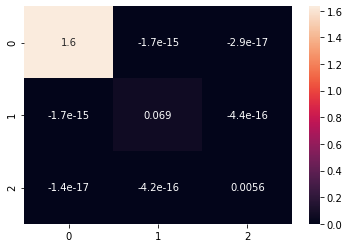

In [46]:
ax = sns.heatmap(Lambda_from_pca, annot=True)

In [47]:
print(100 * np.diag(Lambda_from_pca) / total_variance)
print('{:.6}% of total variance explained'.format(100 * np.sum(np.diag(Lambda_from_pca)) / total_variance))

[95.53366571  4.0667419   0.32890998]
99.9293% of total variance explained


In [51]:
Lambda_from_decoder_weights = w2 @ C @ w2.T

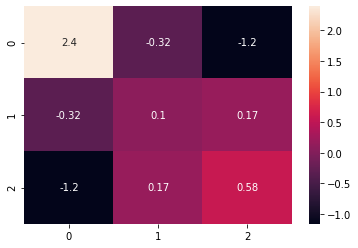

In [49]:
ax = sns.heatmap(Lambda_from_decoder_weights, annot=True)
plt.show()

In [52]:
Lambda_from_decoder_lsv = ae_decoder_lsv.T @ C @ ae_decoder_lsv

In [53]:
print(100*np.diag(Lambda_from_decoder_lsv) / total_variance)
print('{:.6}% of total variance explained'.format(100*np.sum(np.diag(Lambda_from_decoder_lsv)) / total_variance))

[78.41341649 13.37438204  8.13970023]
99.9275% of total variance explained


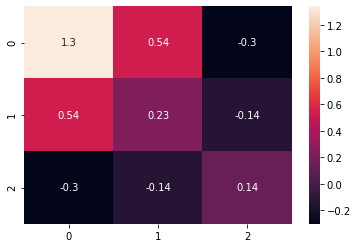

In [54]:
ax = sns.heatmap(Lambda_from_decoder_lsv, annot=True)
plt.show()

# Ajuste del modelo

In [55]:
df_ae_recon = ae_model.predict(df.values)

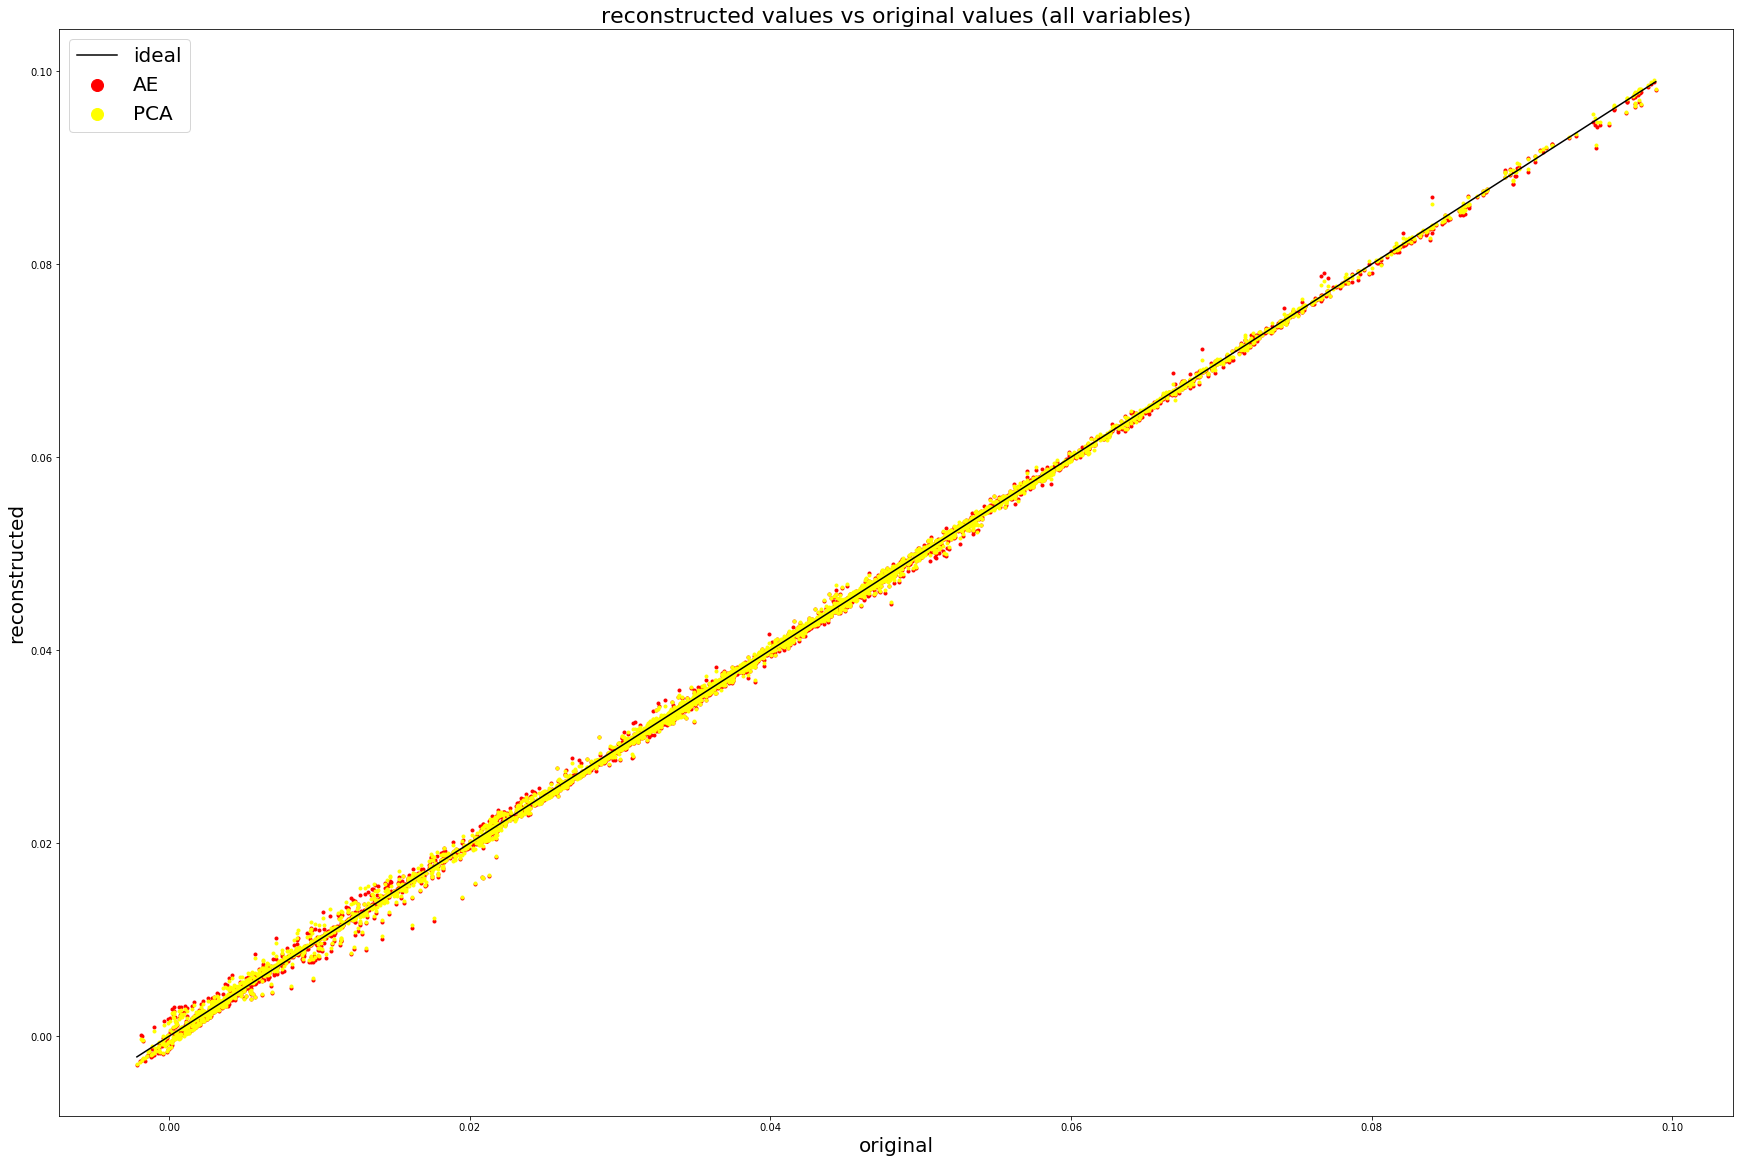

In [56]:
plt.figure(figsize=(30,20))
plt.title('reconstructed values vs original values (all variables)'
         , fontsize=22)
xy = np.linspace(df.values.min(), df.values.max(), 2)

plt.plot(xy, xy, c='black') # y = x
plt.scatter(df.values, df_ae_recon, marker='.', c='red') # ae recon vs original data
plt.scatter(df.values, df_pca_recon, marker='.', c='yellow') # pca preimage vs original data

plt.xlabel('original', fontsize=20)
plt.ylabel('reconstructed', fontsize=20)
plt.legend(['ideal', 'AE', 'PCA'], fontsize=20, markerscale=4);

# Grafico visto desde 2 componentes principales

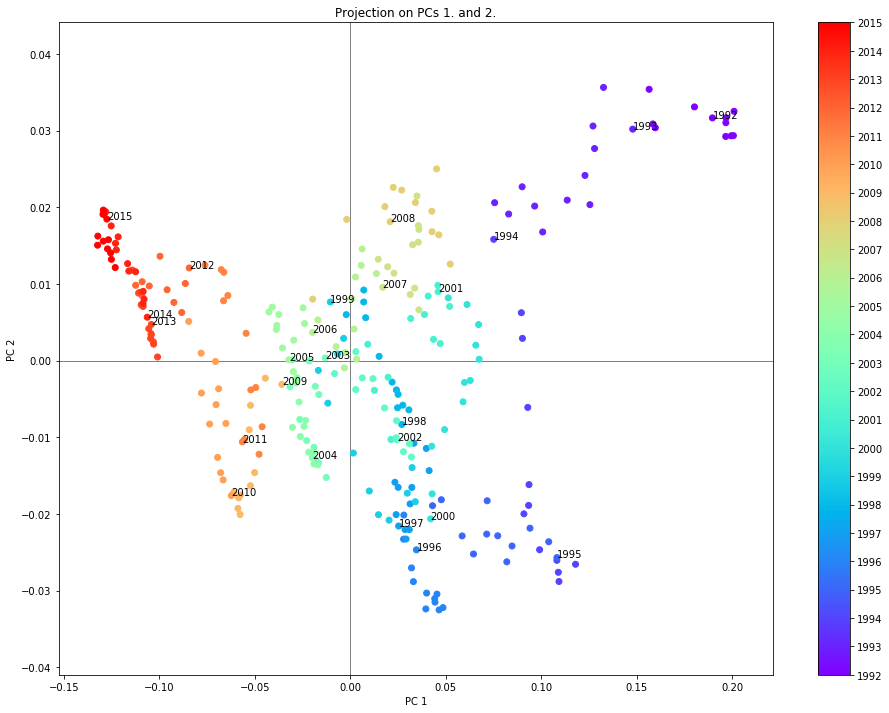

In [57]:
pc1 = 0
pc2 = 1

merged_years = 1

fig = plt.figure(figsize=(16,12))
plt.title('Projection on PCs {0}. and {1}.'.format(pc1+1,pc2+1))
plt.xlabel('PC '+str(pc1+1))
plt.ylabel('PC '+str(pc2+1))
plt.axhline(y=0,c="grey",linewidth=1.0,zorder=0)
plt.axvline(x=0,c="grey",linewidth=1.0,zorder=0)
    
sc = plt.scatter(df_pca.loc[:, pc1], df_pca.loc[:, pc2], c = [d.year for d in df_pca.index], cmap='rainbow')
cb = plt.colorbar(sc)
cb.set_ticks(ticks=np.unique([d.year for d in df_pca.index])[::1])
cb.set_ticklabels(np.unique([d.year for d in df_pca.index])[::1])

for year in range(df_pca.index.min().year, df_pca.index.max().year+1, merged_years):
    year_start = df_pca.index[df_pca.index.searchsorted(datetime(year, 1, 1))]
    year_end = df_pca.index[df_pca.index.searchsorted(datetime(year + merged_years-1, 12, 31))]
    
    plt.annotate('{0}'.format(year), xy=(df_pca.loc[year_start, pc1],df_pca.loc[year_start, pc2]), 
                 xytext=(df_pca.loc[year_start,pc1],df_pca.loc[year_start,pc2]));


# Autoencoders  en los componentes

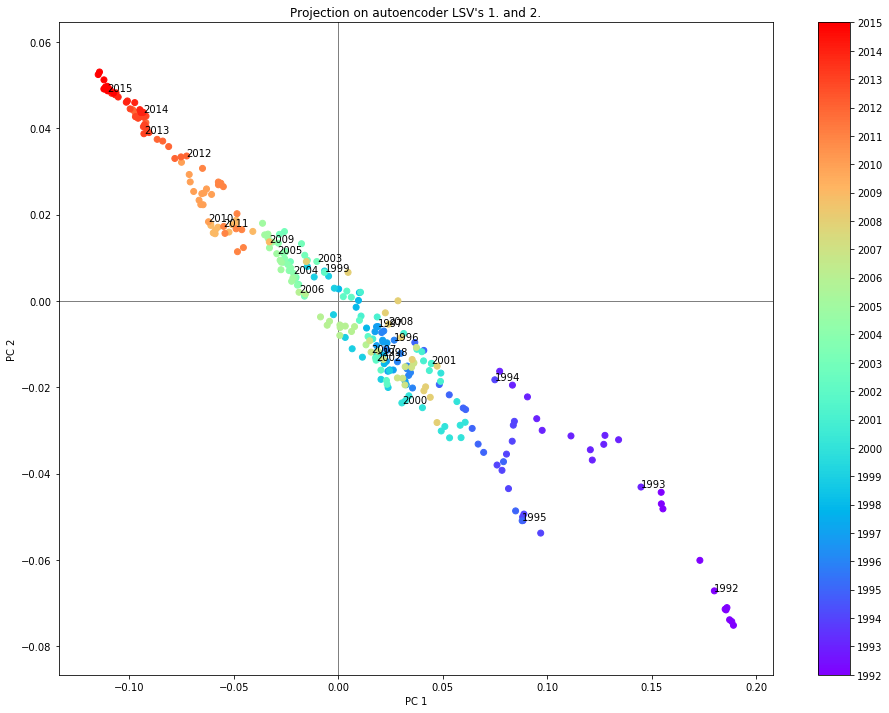

In [58]:
pc1 = 0
pc2 = 1

merged_years = 1
fig = plt.figure(figsize=(16, 12))
plt.title('Projection on autoencoder LSV\'s {0}. and {1}.'.format(pc1+1,pc2+1))
plt.xlabel('PC '+str(pc1+1))
plt.ylabel('PC '+str(pc2+1))
plt.axhline(y=0,c="grey", linewidth=1.0,zorder=0)
plt.axvline(x=0,c="grey", linewidth=1.0,zorder=0)
    
sc = plt.scatter(-df_ae.loc[:,pc1], df_ae.loc[:,pc2], 
                 c=[d.year for d in df_ae.index], cmap='rainbow')
cb = plt.colorbar(sc)
cb.set_ticks(ticks=np.unique([d.year for d in df_ae.index])[::1])
cb.set_ticklabels(np.unique([d.year for d in df_ae.index])[::1])

for year in range(df_ae.index.min().year, df_ae.index.max().year+1, merged_years):
    year_start = df_ae.index[df_ae.index.searchsorted(datetime(year,1,1))]
    year_end = df_ae.index[df_ae.index.searchsorted(datetime(year+merged_years-1,12,31))]
    plt.annotate('{0}'.format(year), xy=(-df_ae.loc[year_start,pc1],df_ae.loc[year_start,pc2]), 
                 xytext=(-df_ae.loc[year_start,pc1],df_ae.loc[year_start,pc2]));

# Reconstruccion por variable

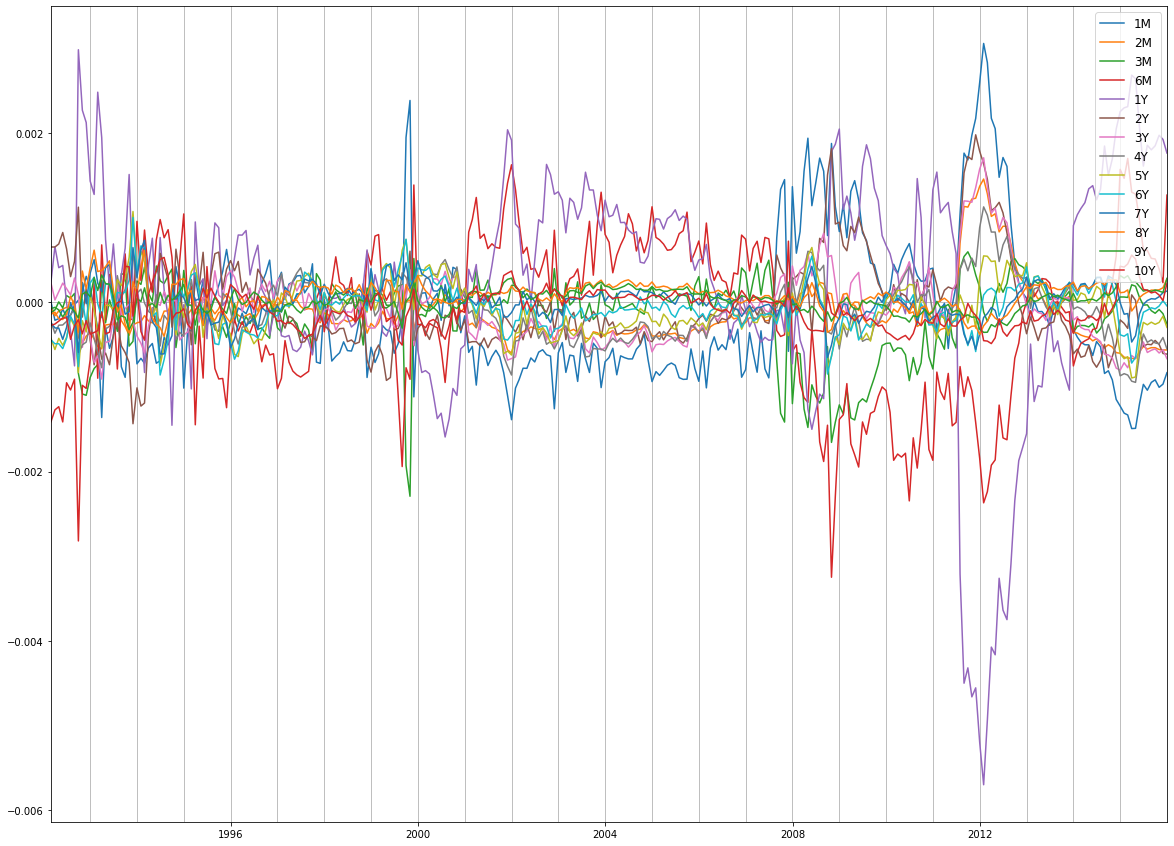

In [59]:
plt.figure(figsize=(20,15))
plt.plot(df.index, pd.DataFrame(df_ae_recon - df))
plt.legend(df.columns, fontsize=12, loc='upper right')
plt.xlim(df.index.min(), df.index.max())
plt.axhline(y=0,c="grey",linewidth=0.5,zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(datetime(i,1,1))-1],
                c="grey", linewidth=0.5, zorder=0)

# Autoencoder profundo

In [60]:
def DeepAE(y, dimension, learning_rate = 1e-4, regularization = 5e-4, epochs=10):
    input = Input(shape=(y.shape[1],))
    encoded1 = Dense(np.int(2*dimension), activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(input)
    encoded2 = Dense(dimension, activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(encoded1)
    decoded1 = Dense(np.int(y.shape[1]/2), activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(encoded2)
    decoded2 = Dense(y.shape[1], activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(decoded1)
    
    autoencoder = models.Model(input, decoded2)
    autoencoder.compile(optimizer=optimizers.adam_v2.Adam(lr=learning_rate), loss='mean_squared_error')
    
    autoencoder.fit(y, y, epochs=epochs, batch_size=4, shuffle=True)
    
    return autoencoder

In [61]:
deepAE_model = DeepAE(df, 3, regularization=0, epochs=1000)

Epoch 1/1000
72/72 [==============================] - 1s 1ms/step - loss: 0.0024
Epoch 2/1000
72/72 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 3/1000
72/72 [==============================] - 0s 1ms/step - loss: 8.7953e-04
Epoch 4/1000
72/72 [==============================] - 0s 2ms/step - loss: 5.8654e-04
Epoch 5/1000
72/72 [==============================] - 0s 1ms/step - loss: 5.0746e-04
Epoch 6/1000
72/72 [==============================] - 0s 1ms/step - loss: 4.1315e-04
Epoch 7/1000
72/72 [==============================] - 0s 1ms/step - loss: 4.1790e-04
Epoch 8/1000
72/72 [==============================] - 0s 1ms/step - loss: 3.4660e-04
Epoch 9/1000
72/72 [==============================] - 0s 2ms/step - loss: 3.1963e-04
Epoch 10/1000
72/72 [==============================] - 0s 1ms/step - loss: 2.8268e-04
Epoch 11/1000
72/72 [==============================] - 0s 2ms/step - loss: 2.8980e-04
Epoch 12/1000
72/72 [==============================] - 0s 2ms/step - lo

72/72 [==============================] - 0s 2ms/step - loss: 1.7632e-05
Epoch 97/1000
72/72 [==============================] - 0s 2ms/step - loss: 1.8065e-05
Epoch 98/1000
72/72 [==============================] - 0s 2ms/step - loss: 1.9226e-05
Epoch 99/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.8333e-05
Epoch 100/1000
72/72 [==============================] - 0s 1ms/step - loss: 2.1315e-05
Epoch 101/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.8766e-05
Epoch 102/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.9268e-05
Epoch 103/1000
72/72 [==============================] - 0s 1ms/step - loss: 2.1752e-05
Epoch 104/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.6615e-05
Epoch 105/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.8557e-05
Epoch 106/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.7603e-05
Epoch 107/1000
72/72 [==============================] - 0s 1m

72/72 [==============================] - 0s 1ms/step - loss: 6.1491e-06
Epoch 191/1000
72/72 [==============================] - 0s 1ms/step - loss: 5.5885e-06
Epoch 192/1000
72/72 [==============================] - 0s 1ms/step - loss: 5.7557e-06
Epoch 193/1000
72/72 [==============================] - 0s 2ms/step - loss: 5.2624e-06
Epoch 194/1000
72/72 [==============================] - 0s 1ms/step - loss: 5.0924e-06
Epoch 195/1000
72/72 [==============================] - 0s 1ms/step - loss: 5.2938e-06
Epoch 196/1000
72/72 [==============================] - 0s 1ms/step - loss: 5.0607e-06
Epoch 197/1000
72/72 [==============================] - 0s 2ms/step - loss: 5.3080e-06
Epoch 198/1000
72/72 [==============================] - 0s 2ms/step - loss: 4.6976e-06
Epoch 199/1000
72/72 [==============================] - 0s 2ms/step - loss: 4.6936e-06
Epoch 200/1000
72/72 [==============================] - 0s 2ms/step - loss: 4.5477e-06
Epoch 201/1000
72/72 [==============================] - 0s

72/72 [==============================] - 0s 1ms/step - loss: 1.8732e-06
Epoch 285/1000
72/72 [==============================] - 0s 2ms/step - loss: 1.8161e-06
Epoch 286/1000
72/72 [==============================] - 0s 1ms/step - loss: 2.0105e-06
Epoch 287/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.7397e-06
Epoch 288/1000
72/72 [==============================] - 0s 1ms/step - loss: 2.0145e-06
Epoch 289/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.9948e-06
Epoch 290/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.9161e-06
Epoch 291/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.9426e-06
Epoch 292/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.7930e-06
Epoch 293/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.9684e-06
Epoch 294/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.6884e-06
Epoch 295/1000
72/72 [==============================] - 0s

72/72 [==============================] - 0s 1ms/step - loss: 1.7020e-06
Epoch 379/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.7759e-06
Epoch 380/1000
72/72 [==============================] - 0s 2ms/step - loss: 1.8040e-06
Epoch 381/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.6716e-06
Epoch 382/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.8743e-06
Epoch 383/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.7749e-06
Epoch 384/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.6413e-06
Epoch 385/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.7401e-06
Epoch 386/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.7755e-06
Epoch 387/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.7316e-06
Epoch 388/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.8986e-06
Epoch 389/1000
72/72 [==============================] - 0s

72/72 [==============================] - 0s 2ms/step - loss: 1.7468e-06
Epoch 473/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.6969e-06
Epoch 474/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.6865e-06
Epoch 475/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.7108e-06
Epoch 476/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.8827e-06
Epoch 477/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.7262e-06
Epoch 478/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.8814e-06
Epoch 479/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.7711e-06
Epoch 480/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.6140e-06
Epoch 481/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.6415e-06
Epoch 482/1000
72/72 [==============================] - 0s 2ms/step - loss: 1.6494e-06
Epoch 483/1000
72/72 [==============================] - 0s

72/72 [==============================] - 0s 1ms/step - loss: 1.6092e-06
Epoch 567/1000
72/72 [==============================] - 0s 2ms/step - loss: 1.5899e-06
Epoch 568/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.6583e-06
Epoch 569/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.6516e-06
Epoch 570/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.6525e-06
Epoch 571/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.7802e-06
Epoch 572/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.6076e-06
Epoch 573/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.6104e-06
Epoch 574/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.7870e-06
Epoch 575/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.6774e-06
Epoch 576/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.5875e-06
Epoch 577/1000
72/72 [==============================] - 0s

72/72 [==============================] - 0s 2ms/step - loss: 1.5828e-06
Epoch 661/1000
72/72 [==============================] - 0s 2ms/step - loss: 1.6059e-06
Epoch 662/1000
72/72 [==============================] - 0s 2ms/step - loss: 1.5535e-06A: 0s - loss: 1.5656e-0
Epoch 663/1000
72/72 [==============================] - 0s 2ms/step - loss: 1.6412e-06
Epoch 664/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.5932e-06
Epoch 665/1000
72/72 [==============================] - 0s 2ms/step - loss: 1.5325e-06
Epoch 666/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.6277e-06
Epoch 667/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.4885e-06
Epoch 668/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.3696e-06
Epoch 669/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.4555e-06
Epoch 670/1000
72/72 [==============================] - 0s 2ms/step - loss: 1.3531e-06
Epoch 671/1000
72/72 [=============

72/72 [==============================] - 0s 2ms/step - loss: 1.1740e-06
Epoch 754/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.2028e-06
Epoch 755/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.2448e-06
Epoch 756/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.2340e-06
Epoch 757/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.2561e-06
Epoch 758/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.2195e-06
Epoch 759/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.1278e-06
Epoch 760/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.1839e-06
Epoch 761/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.1239e-06
Epoch 762/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.1613e-06
Epoch 763/1000
72/72 [==============================] - 0s 1ms/step - loss: 1.2162e-06
Epoch 764/1000
72/72 [==============================] - 0s

72/72 [==============================] - 0s 1ms/step - loss: 8.2121e-07
Epoch 848/1000
72/72 [==============================] - 0s 1ms/step - loss: 7.7846e-07
Epoch 849/1000
72/72 [==============================] - 0s 1ms/step - loss: 8.4155e-07
Epoch 850/1000
72/72 [==============================] - 0s 1ms/step - loss: 7.8069e-07
Epoch 851/1000
72/72 [==============================] - 0s 1ms/step - loss: 8.4830e-07
Epoch 852/1000
72/72 [==============================] - 0s 2ms/step - loss: 7.2999e-07
Epoch 853/1000
72/72 [==============================] - 0s 1ms/step - loss: 7.6395e-07
Epoch 854/1000
72/72 [==============================] - 0s 1ms/step - loss: 7.7293e-07
Epoch 855/1000
72/72 [==============================] - 0s 1ms/step - loss: 7.3923e-07
Epoch 856/1000
72/72 [==============================] - 0s 1ms/step - loss: 7.1995e-07
Epoch 857/1000
72/72 [==============================] - 0s 1ms/step - loss: 7.6413e-07
Epoch 858/1000
72/72 [==============================] - 0s

72/72 [==============================] - 0s 1ms/step - loss: 4.8381e-07
Epoch 942/1000
72/72 [==============================] - 0s 1ms/step - loss: 4.7366e-07
Epoch 943/1000
72/72 [==============================] - 0s 1ms/step - loss: 4.2419e-07
Epoch 944/1000
72/72 [==============================] - 0s 1ms/step - loss: 4.4561e-07
Epoch 945/1000
72/72 [==============================] - 0s 1ms/step - loss: 4.5745e-07
Epoch 946/1000
72/72 [==============================] - 0s 1ms/step - loss: 4.9245e-07
Epoch 947/1000
72/72 [==============================] - 0s 1ms/step - loss: 4.9707e-07
Epoch 948/1000
72/72 [==============================] - 0s 1ms/step - loss: 4.0905e-07
Epoch 949/1000
72/72 [==============================] - 0s 1ms/step - loss: 4.4846e-07
Epoch 950/1000
72/72 [==============================] - 0s 2ms/step - loss: 4.7104e-07
Epoch 951/1000
72/72 [==============================] - 0s 2ms/step - loss: 4.6529e-07
Epoch 952/1000
72/72 [==============================] - 0s

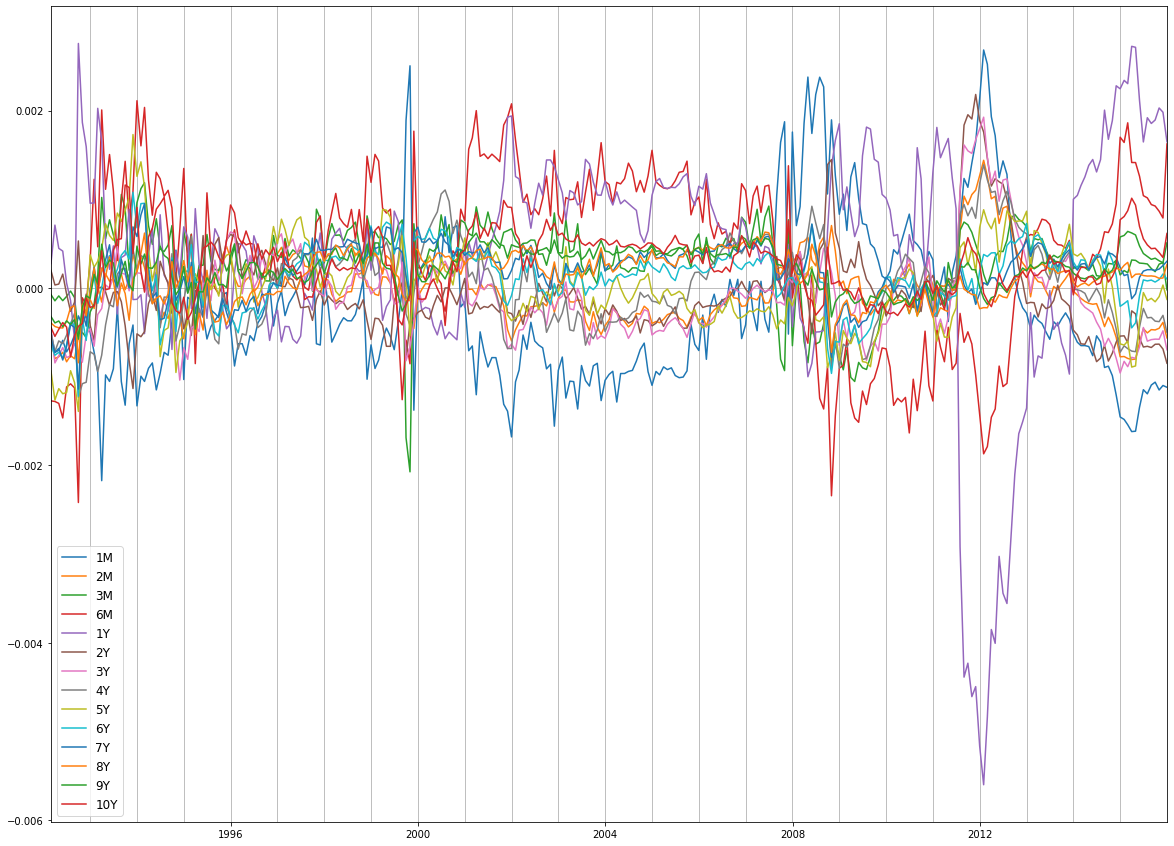

In [62]:
df_deep_recon = deepAE_model.predict(df)

plt.figure(figsize=(20, 15))
plt.plot(df.index, pd.DataFrame(df_deep_recon - df))
plt.xlim(df.index.min(), df.index.max())
plt.legend(df.columns, fontsize=12)
plt.axhline(y=0, c="grey", linewidth=0.5, zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(datetime(i, 1, 1)) - 1],
                c="grey", linewidth=0.5, zorder=0)

# Comparación entre AE lineales, profundos y PCA

In [63]:
pca_rec_errs = np.sqrt(np.sum((df_pca_recon - df)**2, axis=1))

ae_rec_errs = np.sqrt(np.sum((df_ae_recon - df)**2, axis=1))

deep_rec_errs = np.sqrt(np.sum((df_deep_recon - df)**2, axis=1))

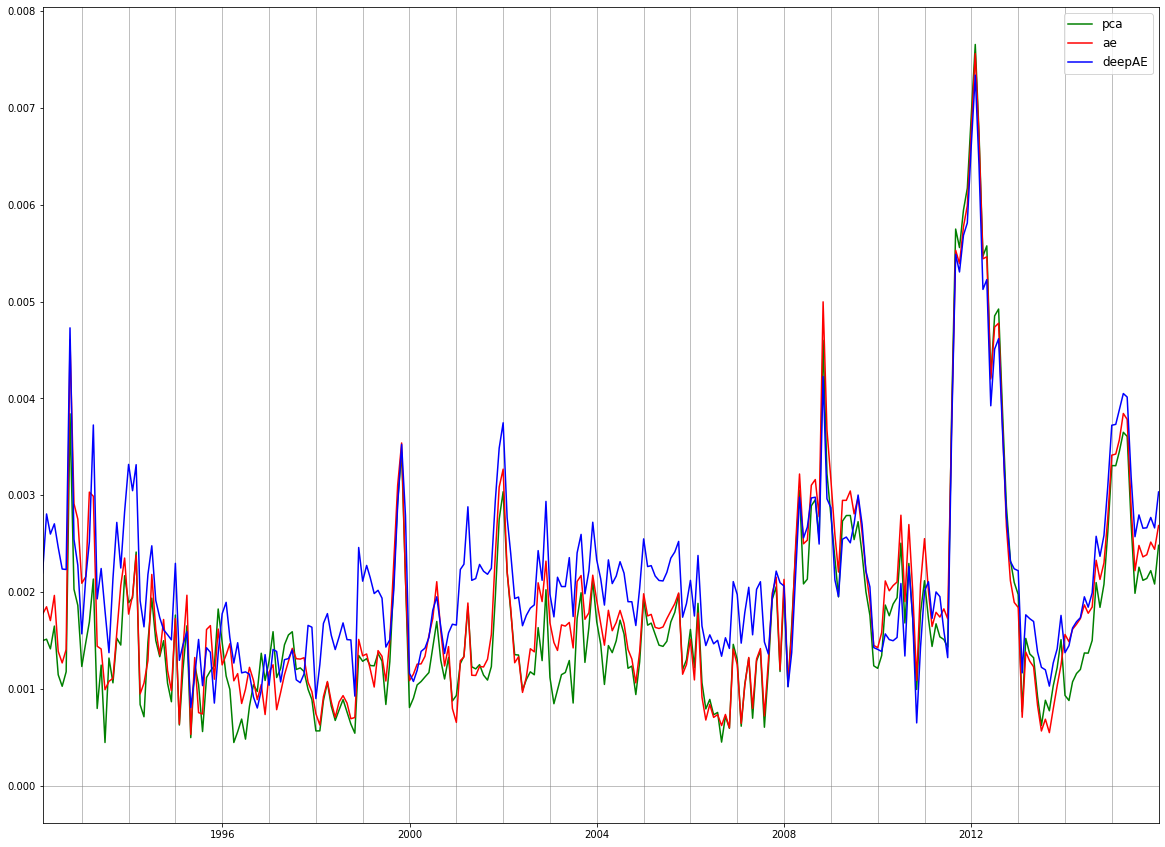

In [64]:
plt.figure(figsize=(20, 15))
plt.plot(df.index, pca_rec_errs, c='green')
plt.plot(df.index, ae_rec_errs, c='red')
plt.plot(df.index, deep_rec_errs, c='blue')
plt.legend(['pca','ae','deepAE'], fontsize=12)
plt.xlim(df.index.min(), df.index.max())
plt.axhline(y=0, c="grey", linewidth=0.5, zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(datetime(i, 1, 1)) - 1],
                c="grey", linewidth=0.5, zorder=0)